In [6]:
import numpy as np
import pandas as pd
import ants
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime; now = datetime.now;t0 = now()

In [4]:
df = pd.read_csv('../Data/comb_df.csv')
df

,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset
0,0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I
1,2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I
2,3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I
3,4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I
4,9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,746,30163,2,8.00,2,136.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II
1498,747,30164,2,10.00,2,115.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II
1499,748,30165,2,12.00,2,120.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II
1500,749,30166,2,10.00,2,112.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II


In [110]:
s = 1
subID = df['participant_id'].values[s]
print(subID)

50004


In [111]:
if df['dataset'].values[s]=='ABIDE I':
    bids_dir = f'~/data/ABIDE/Derivatives/fmriprep/fmriprep/sub-00{subID}/func/'
elif df['dataset'].values[s]=='ABIDE II':
    bids_dir = f'~/data/ABIDE2/Derivatives/test/fmriprep/sub-{subID}/ses-1/func/'
    
bids_dir = os.path.expanduser(bids_dir)
print(bids_dir)

/data/aglinska/data/ABIDE/Derivatives/fmriprep/fmriprep/sub-0050004/func/


In [112]:
files = os.listdir(bids_dir)
files = np.array(files)

files.sort()
files

array(['sub-0050004_task-rest_run-1_desc-confounds_timeseries.json',
       'sub-0050004_task-rest_run-1_desc-confounds_timeseries.tsv',
       'sub-0050004_task-rest_run-1_from-T1w_to-scanner_mode-image_xfm.txt',
       'sub-0050004_task-rest_run-1_from-scanner_to-T1w_mode-image_xfm.txt',
       'sub-0050004_task-rest_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz',
       'sub-0050004_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.json',
       'sub-0050004_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
       'sub-0050004_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json',
       'sub-0050004_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'],
      dtype='<U78')

In [113]:
epi_fn = files[[file.endswith('preproc_bold.nii.gz') for file in files]][0]
mask_fn = files[[file.endswith('brain_mask.nii.gz') for file in files]][0]
conf_fn = files[[file.endswith('confounds_timeseries.tsv') for file in files]][0]

In [114]:
epi_fn = os.path.join(bids_dir,epi_fn)
mask_fn = os.path.join(bids_dir,mask_fn)
conf_fn = os.path.join(bids_dir,conf_fn)

print(epi_fn)
print(mask_fn)
print(conf_fn)

/data/aglinska/data/ABIDE/Derivatives/fmriprep/fmriprep/sub-0050004/func/sub-0050004_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/data/aglinska/data/ABIDE/Derivatives/fmriprep/fmriprep/sub-0050004/func/sub-0050004_task-rest_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/data/aglinska/data/ABIDE/Derivatives/fmriprep/fmriprep/sub-0050004/func/sub-0050004_task-rest_run-1_desc-confounds_timeseries.tsv


In [115]:
epi = ants.image_read(epi_fn)
epi3d = ants.slice_image(epi,axis=3,idx=0)
mask = ants.image_read(mask_fn)
conf = pd.read_csv(conf_fn,delimiter='\t')
n = epi.shape[-1]
tr = epi.spacing[-1]
flat_epi = epi.numpy().reshape(epi.shape[-1],-1)

mean = ants.slice_image(epi,axis=3,idx=0).new_image_like(epi.numpy().mean(axis=3))
mean[mask==0]=0

data = {}
data['epi'] =epi 
data['epi3d'] = epi3d
data['mask'] = mask
data['conf'] = conf
data['mean'] = mean
data['n'] = n
data['tr'] = tr
data['flat_epi'] = flat_epi

In [116]:
def regress(flat_epi,conf,idx=None):
    from sklearn.linear_model import LinearRegression
    keys = ['a_comp_cor_01', 'a_comp_cor_02','a_comp_cor_03', 
            'a_comp_cor_04', 'a_comp_cor_05','trans_x',
           'trans_x_derivative1', 'trans_x_derivative1_power2',
           'trans_x_power2', 'trans_y', 'trans_y_derivative1',
           'trans_y_power2', 'trans_y_derivative1_power2', 'trans_z',
           'trans_z_derivative1', 'trans_z_power2',
           'trans_z_derivative1_power2', 'rot_x', 'rot_x_derivative1',
           'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
           'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
           'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2','rot_z_power2']
    
    if type(idx)==type(None):
        idx = np.arange(flat_epi.shape[0])
    
    
    X = conf[keys].values[idx]
    n = X.shape[0]
    X = np.hstack((X,np.ones(n)[:,np.newaxis])) # Add mean
    X = np.hstack((X,(np.arange(n)+1)[:,np.newaxis])) # Add linear trend
    X = np.hstack((X,((np.arange(n)+1)**2)[:,np.newaxis])) # Add quadratic trend
    #X = np.hstack((X,flat_epi.mean(axis=1)[:,np.newaxis])) # Add Global signal
    X[np.isnan(X)]=0 # Fix NaNs
    
    Y_hat = LinearRegression().fit(X,flat_epi[idx,:]).predict(X) # Fit Predict 
    mat = flat_epi[idx,:] - Y_hat # Residuals
    
    return mat

In [117]:
def plot4d(im,axis=3,idx=0,title=None):
    ants.slice_image(im,axis=axis,idx=idx).plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=title)

In [118]:
def scrub(mat,conf,thresh):
    mat2 = mat[conf['framewise_displacement'].values>thresh,:]
    return mat2

In [119]:
def filt(im,tr,lowf=.01,highf=.1,order=3):
    imfilt = ants.bandpass_filter_matrix(im,tr=tr, lowf=lowf, highf=highf, order=order)
    return imfilt

In [120]:
def make_4depi(inmat,epi):
    'takes in samples x voxels matrix, makes a nii from it'
    #inmat = mat
    #epi = data['epi']

    arr = inmat.transpose().reshape(epi.shape[0],epi.shape[1],epi.shape[2],inmat.shape[0])
    new_im = ants.from_numpy(data=arr,origin=epi.origin,spacing=epi.spacing,direction=epi.direction,has_components=epi.has_components,is_rgb=epi.is_rgb)
    
    return new_im

In [121]:
data['epi']

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (63, 74, 49, 200)
	 Spacing    : (3.125, 3.125, 4.0, 1.5)
	 Origin     : (96.5, 132.5, -78.5, 0.0)
	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

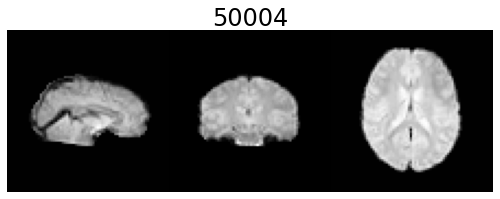

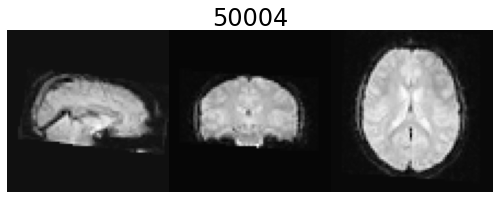

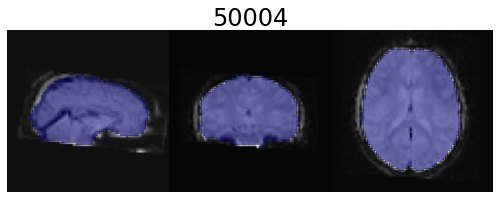

In [122]:
data['mean'].plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=subID)
data['epi3d'].plot_ortho(flat=True,xyz_lines=False,orient_labels=False,title=subID)
data['epi3d'].plot_ortho(data['mask'],flat=True,xyz_lines=False,orient_labels=False,overlay_alpha=.5,title=subID)

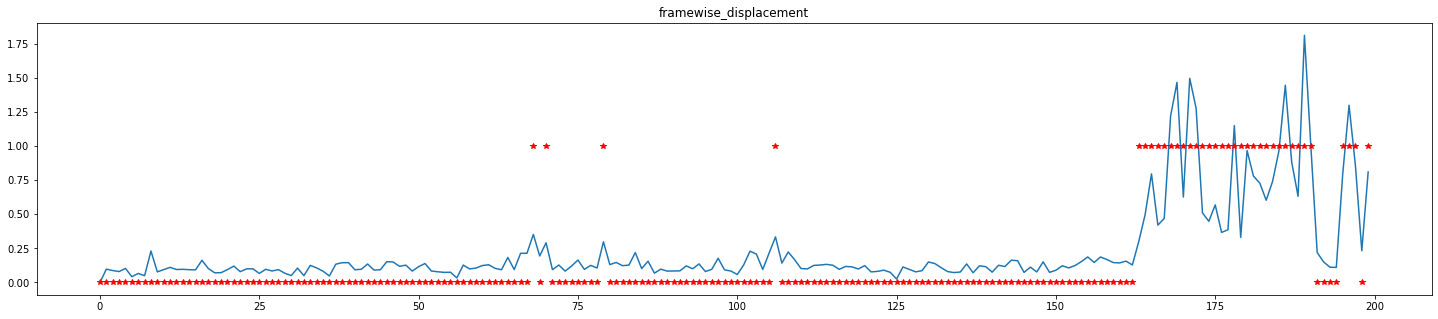

In [123]:
plt.figure(figsize=(25,5))
FD = data['conf']['framewise_displacement'].values
FD[0] = 0 # for cosmetic reasons, first value of FD is always NaN
plt.plot(FD)
plt.plot(FD>.25,'r*')
plt.title('framewise_displacement');

In [124]:
scan_time_1 = data['epi'].shape[-1]*data['tr']/60
scan_time_2 = (FD<.25).sum()*data['tr']/60
print(f'scan time {scan_time_1:.2f} minutes before scrubbing')
print(f'scan time {scan_time_2:.2f} minutes after scrubbing')

scan time 5.00 minutes before scrubbing
scan time 4.10 minutes after scrubbing


In [125]:
thresh = .25 # FD treshold

scrub_idx = data['conf']['framewise_displacement'].values > thresh
epi_scrubbed = data['epi'].numpy()[:,:,:,~scrub_idx]

mat = epi_scrubbed.reshape(-1,epi_scrubbed.shape[-1]).transpose()
scrubbed_nii = make_4depi(mat,data['epi'])

rmat = regress(mat,data['conf'].iloc[~scrub_idx])

rmat_nii = make_4depi(rmat,data['epi'])
rmat_nii[data['mask'].numpy()==0]=0

In [126]:
rfmat_nii = filt(im=rmat_nii,tr=data['tr'],lowf=.01,highf=.1,order=3)
srfmat_nii = ants.smooth_image(image=rfmat_nii,sigma=4,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)

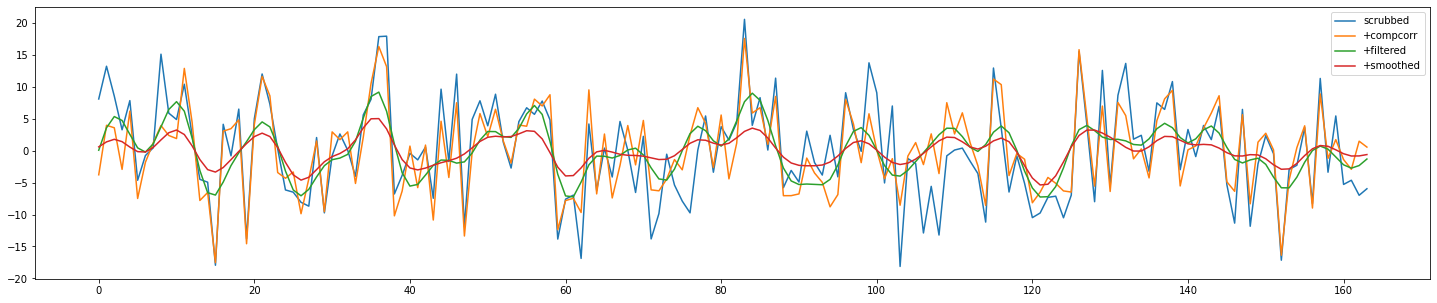

In [127]:
plt.figure(figsize=(25,5))
plt.plot(epi_scrubbed[48,26,26,:]-epi_scrubbed[48,26,26,:].mean())
plt.plot(rmat_nii.numpy()[48,26,26,:])
plt.plot(rfmat_nii.numpy()[48,26,26,:])
plt.plot(srfmat_nii.numpy()[48,26,26,:])
plt.legend(['scrubbed','+compcorr','+filtered','+smoothed']);

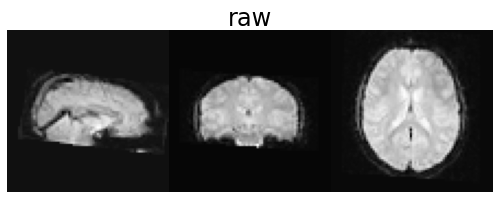

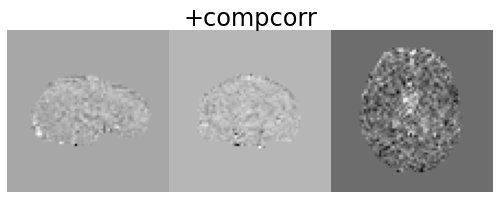

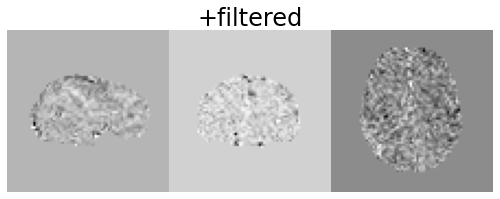

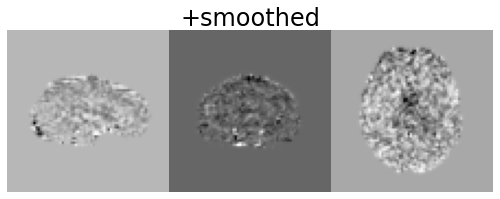

In [128]:
plot4d(data['epi'],title='raw')
plot4d(rmat_nii,title='+compcorr')
plot4d(rfmat_nii,title='+filtered')
plot4d(srfmat_nii,title='+smoothed')

In [129]:
ofdir = os.path.expanduser('~/BC-fMRI-AE/Assets/data_preprocessed')
if not os.path.exists(ofdir):
    os.mkdir(ofdir)
    
subdir = os.path.join(ofdir,f'{subID}')
if not os.path.exists(subdir):
    os.mkdir(subdir)

In [130]:
data['epi'].to_filename(os.path.join(subdir,f'raw-{subID}_bold.nii.gz'))
data['mask'].to_filename(os.path.join(subdir,f'mask-{subID}_bold.nii.gz'))
rmat_nii.to_filename(os.path.join(subdir,f'rc-{subID}_bold.nii.gz'))
rfmat_nii.to_filename(os.path.join(subdir,f'frc-{subID}_bold.nii.gz'))
srfmat_nii.to_filename(os.path.join(subdir,f'sfrc-{subID}_bold.nii.gz'))
data['mean'].to_filename(os.path.join(subdir,f'mean-{subID}_bold.nii.gz'))
data['conf'].to_csv(os.path.join(subdir,f'conf-{subID}.csv'))

In [131]:
atlas.to_filename(os.path.join(subdir,f'atlas-{subID}.nii.gz'))

In [132]:
atlas = ants.image_read('../Data/YeoAtlas/Atlas_parc-7n_2mm.nii')
atlas = ants.resample_image_to_target(image=atlas,target=data['epi3d'],interp_type='multiLabel',imagetype=0,verbose=False)

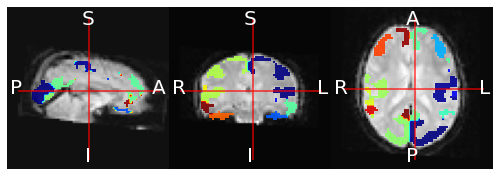

In [133]:
data['epi3d'].plot_ortho(atlas,flat=True)

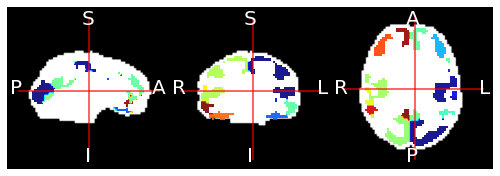

In [134]:
data['mask'].plot_ortho(atlas,flat=True)